In [3]:
!pip install gpytorch
!pip install botorch 

In [5]:
import numpy as np
import seaborn as sns
import warnings
import copy
import matplotlib.pyplot as plt
import random
import torch
import gpytorch
from botorch.fit import fit_gpytorch_model
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style("darkgrid")
import matplotlib

#matplotlib.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 15

## 学習用コード

In [7]:
# 配列の正規化
def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

# 人工データ生成
class DataGenerator(object):
    def __init__(self, random_seed, sample_size_all, x_low, x_up, err_loc, err_var, object_func):
        self.random_seed=random_seed
        self.sample_size_all=sample_size_all 
        self.x_low=x_low
        self.x_up=x_up
        self.err_loc=err_loc
        self.err_var=err_var
        self.object_func=object_func

    def generate_data(self):
        np.random.seed(self.random_seed)
        x_out = np.linspace(self.x_low, self.x_up, self.sample_size_all).reshape(-1, 1)
        f_out = f(x_out) 
        err = np.random.normal(loc=self.err_loc, scale=self.err_var, size=self.sample_size_all).reshape(-1, 1)
        y_out = f_out + err

        return x_out, y_out, f_out

# ガウス過程モデルの定義
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, 
                 lengthscale_prior=None, outputscale_prior=None):
        super(GPModel, self).__init__(train_x,
                                      train_y,
                                      likelihood,
                                      )
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(
        #    gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        #    outputscale_prior=outputscale_prior
        #    )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# カーネルのハイパーパラメータチューニング (勾配法による周辺尤度最大化に基づく)
class Trainer(object):
    
    def __init__(self, gpr, likelihood, optimizer, mll):
        self.gpr = gpr
        self.likelihood = likelihood
        self.optimizer = optimizer
        self.mll = mll

    def update_hyperparameter(self, epochs):
        self.gpr.train()
        self.likelihood.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            output = self.gpr(self.gpr.train_inputs[0])

            loss = - self.mll(output, self.gpr.train_targets)
            loss.backward()
            self.optimizer.step()

            if epoch % (epochs//10) == 0:
                print('Epoch %d/%d - Loss: %.3f ' % (
                    epoch + 1, epochs, loss.item(),
                    ))

# LSEのための獲得関数
def straddle(mean, std, th):
    return 1.96 * std - np.abs(mean - th)

## データとモデルの準備

In [17]:
# ブラックボックス関数
def f(x):
    res = (
        x
        + 7 * np.exp(-0.5 * np.square(x - 3) / np.square(1))
        + 5 * np.sin(2 * x)
        - 7 * np.exp(-0.5 * np.square(x - 3.8) / np.square(0.35))
        + 1 * np.exp(-0.5 * np.square(x - 0.8) / np.square(0.4))
    )
    return res

# しきい値 (既知の場合)
th = 5

# データの生成
data_generator = DataGenerator(random_seed=0, sample_size_all=200, x_low=0.5, x_up=5.5, err_loc=0.0, err_var=0.5, object_func=f)
x, y, f_true = data_generator.generate_data()

x_current = copy.deepcopy(x)
y_current = copy.deepcopy(y)
f_true_current = copy.deepcopy(f_true)


# 観測済みデータの保存場所
obs_x = []
obs_y = []

# 初期点を指定
q = random.sample(list(range(0, 200, 1)), 2)
for i in range(len(q)):
    obs_x.append(x[q[i]])
    obs_y.append(y[q[i]])

# 既に観測した点は観測しない場合は使用する
#for idx in sorted(q, reverse=True):
#    x_current = np.delete(x_current, idx)
#    y_current = np.delete(y_current, idx)
#    f_true_current = np.delete(f_true_current, idx)

# GPyTorchに入力できるように加工
## GPでは入力は多次元前提なので (num_data, dim) という shape
## 一方で出力は一次元前提なので (num_data) という形式にする
train_X = torch.from_numpy(np.array(obs_x).astype(np.float32)).clone().reshape(len(obs_x), 1)
train_Y = torch.from_numpy(np.array(obs_y).astype(np.float32)).clone().reshape(len(obs_y))


## レベル集合推定のための能動学習

Epoch 1/2000 - Loss: 15.622 
Epoch 201/2000 - Loss: 5.460 
Epoch 401/2000 - Loss: 3.836 
Epoch 601/2000 - Loss: 3.142 
Epoch 801/2000 - Loss: 2.748 
Epoch 1001/2000 - Loss: 2.521 
Epoch 1201/2000 - Loss: 2.413 
Epoch 1401/2000 - Loss: 2.365 
Epoch 1601/2000 - Loss: 2.347 
Epoch 1801/2000 - Loss: 2.340 
Epoch 1/2000 - Loss: 13.064 
Epoch 201/2000 - Loss: 4.510 
Epoch 401/2000 - Loss: 3.303 
Epoch 601/2000 - Loss: 2.823 
Epoch 801/2000 - Loss: 2.573 
Epoch 1001/2000 - Loss: 2.427 
Epoch 1201/2000 - Loss: 2.334 
Epoch 1401/2000 - Loss: 2.265 
Epoch 1601/2000 - Loss: 2.197 
Epoch 1801/2000 - Loss: 2.146 
Epoch 1/2000 - Loss: 10.057 
Epoch 201/2000 - Loss: 3.883 
Epoch 401/2000 - Loss: 3.012 
Epoch 601/2000 - Loss: 2.673 
Epoch 801/2000 - Loss: 2.501 
Epoch 1001/2000 - Loss: 2.396 
Epoch 1201/2000 - Loss: 2.307 
Epoch 1401/2000 - Loss: 2.190 
Epoch 1601/2000 - Loss: 2.166 
Epoch 1801/2000 - Loss: 2.159 
Epoch 1/2000 - Loss: 8.285 
Epoch 201/2000 - Loss: 3.493 
Epoch 401/2000 - Loss: 2.816 


/Users/MATSUIKota/anaconda/envs/breeds-benchmarks/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 1/2000 - Loss: 4.625 
Epoch 201/2000 - Loss: 2.376 
Epoch 401/2000 - Loss: 2.118 
Epoch 601/2000 - Loss: 1.978 
Epoch 801/2000 - Loss: 1.800 
Epoch 1001/2000 - Loss: 1.615 
Epoch 1201/2000 - Loss: 1.569 
Epoch 1401/2000 - Loss: 1.557 
Epoch 1601/2000 - Loss: 1.551 
Epoch 1801/2000 - Loss: 1.547 
Epoch 1/2000 - Loss: 4.494 
Epoch 201/2000 - Loss: 2.335 
Epoch 401/2000 - Loss: 2.088 
Epoch 601/2000 - Loss: 1.945 
Epoch 801/2000 - Loss: 1.733 
Epoch 1001/2000 - Loss: 1.563 
Epoch 1201/2000 - Loss: 1.528 
Epoch 1401/2000 - Loss: 1.518 
Epoch 1601/2000 - Loss: 1.513 
Epoch 1801/2000 - Loss: 1.510 
Epoch 1/2000 - Loss: 4.348 
Epoch 201/2000 - Loss: 2.290 
Epoch 401/2000 - Loss: 2.052 
Epoch 601/2000 - Loss: 1.903 
Epoch 801/2000 - Loss: 1.646 
Epoch 1001/2000 - Loss: 1.509 
Epoch 1201/2000 - Loss: 1.482 
Epoch 1401/2000 - Loss: 1.474 
Epoch 1601/2000 - Loss: 1.469 
Epoch 1801/2000 - Loss: 1.466 
Epoch 1/2000 - Loss: 4.230 
Epoch 201/2000 - Loss: 2.251 
Epoch 401/2000 - Loss: 2.024 
Epo

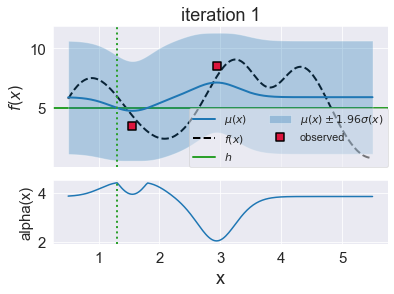

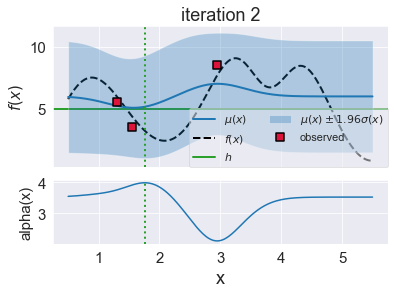

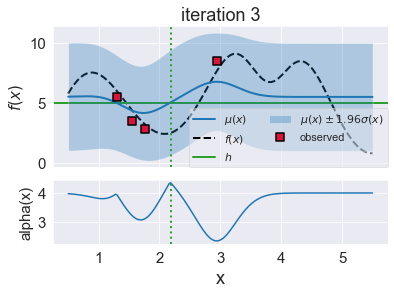

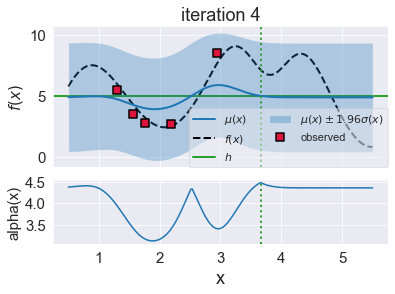

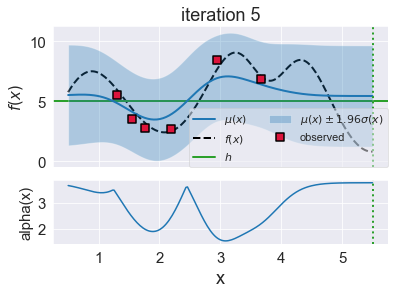

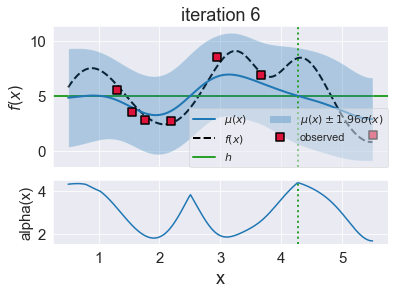

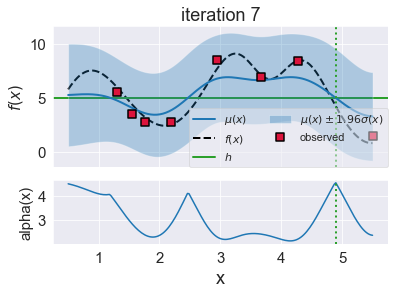

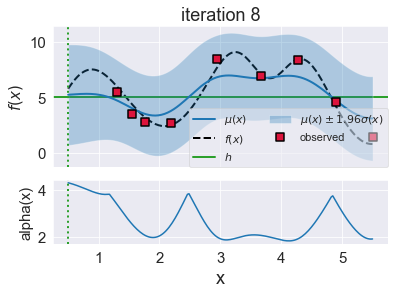

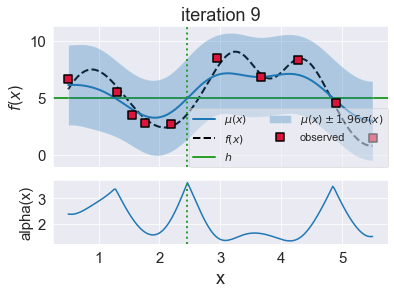

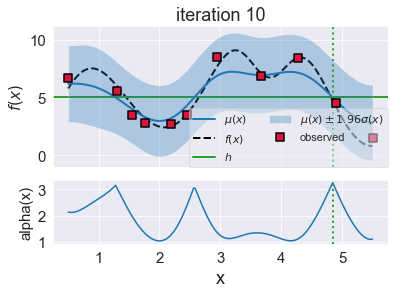

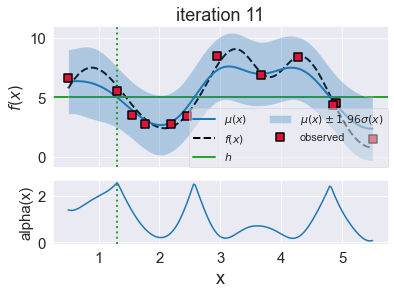

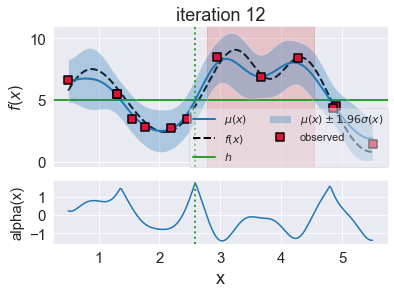

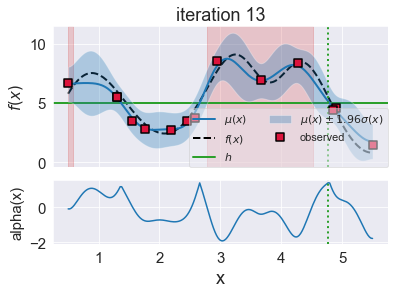

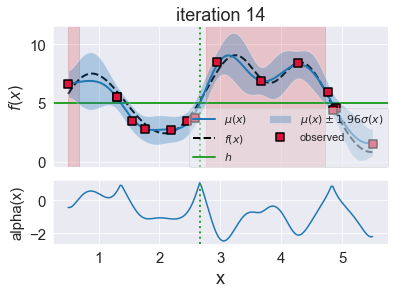

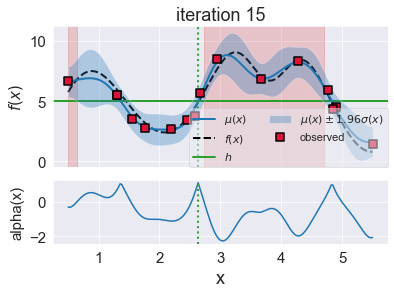

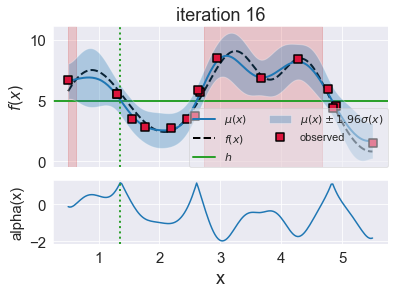

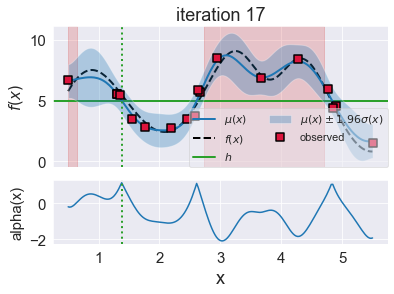

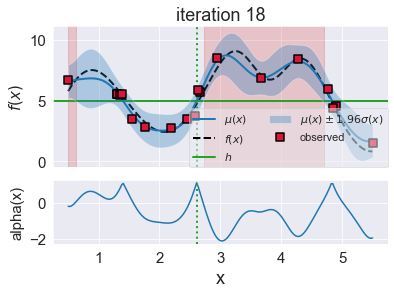

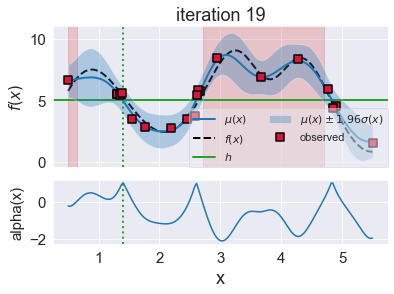

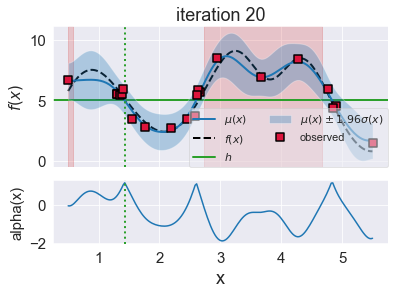

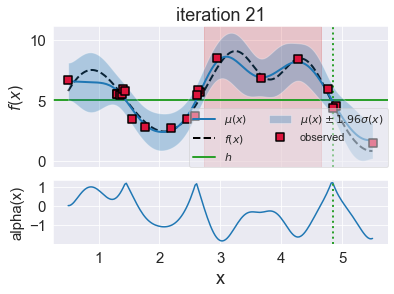

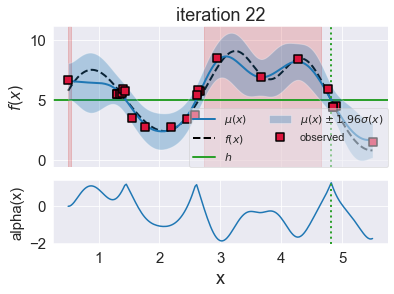

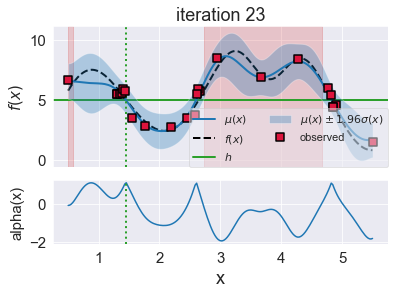

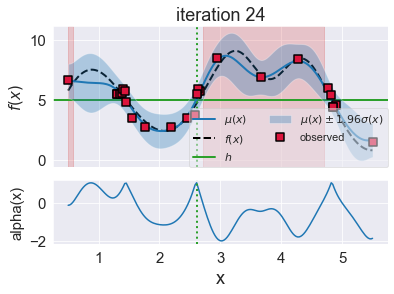

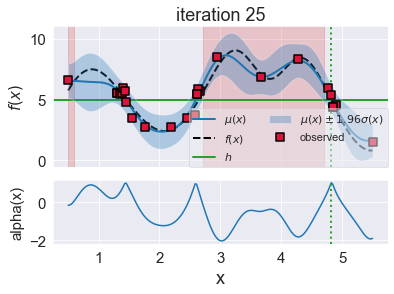

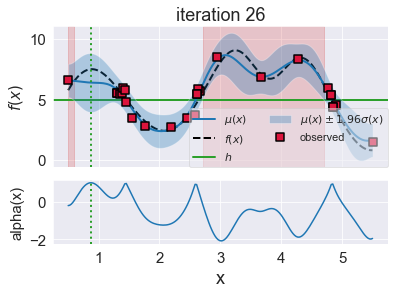

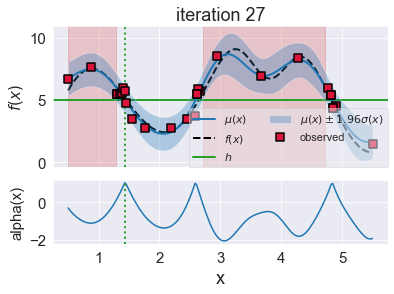

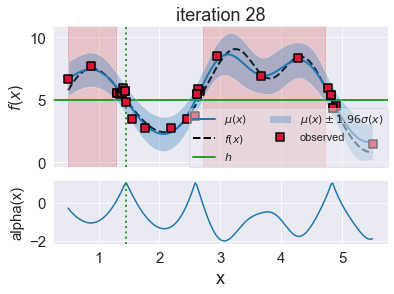

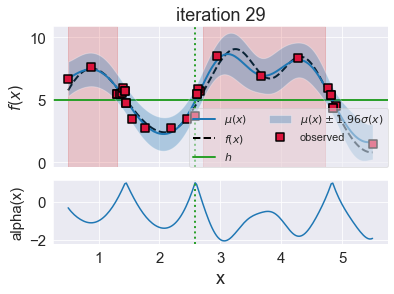

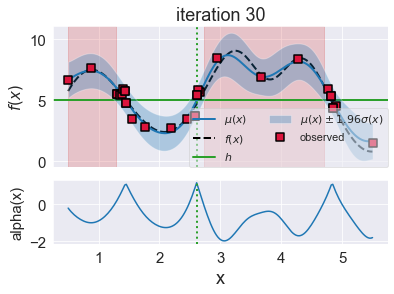

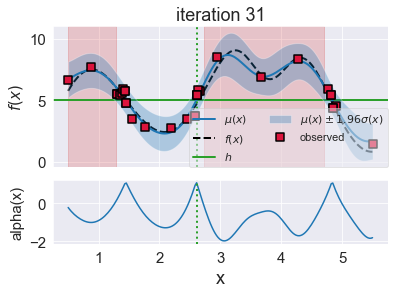

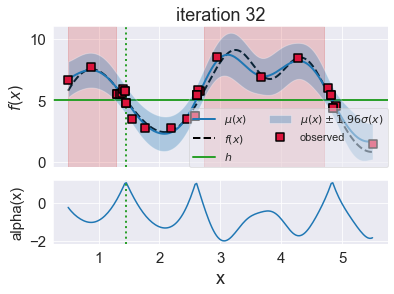

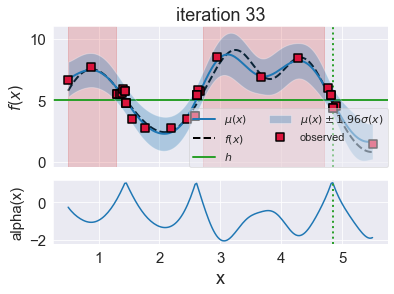

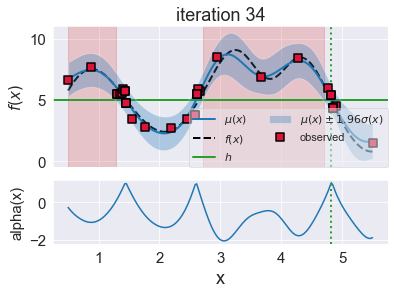

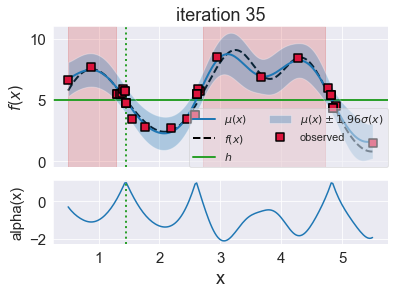

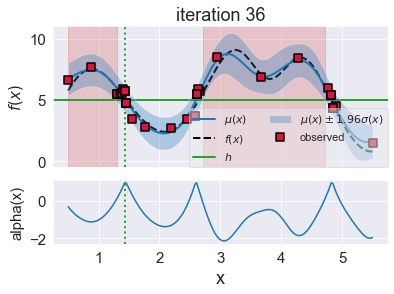

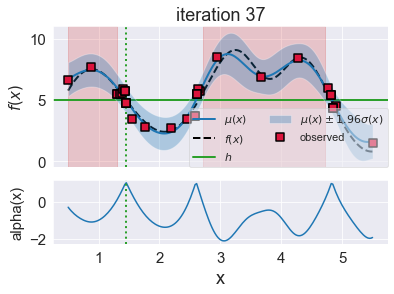

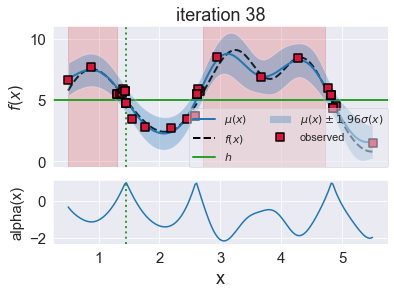

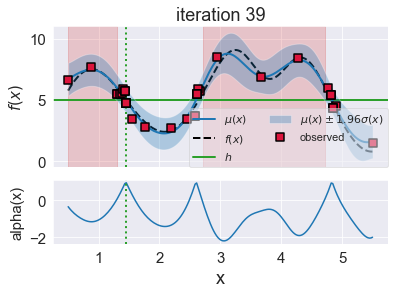

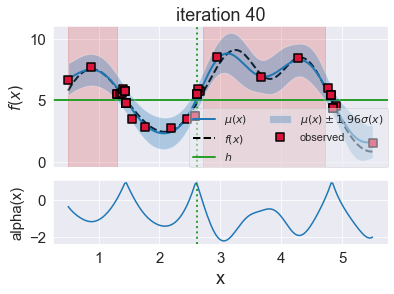

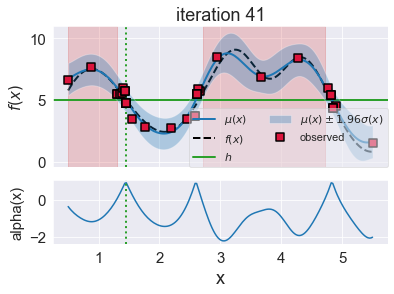

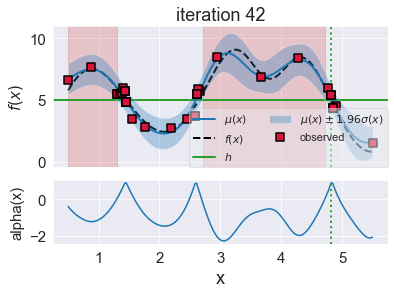

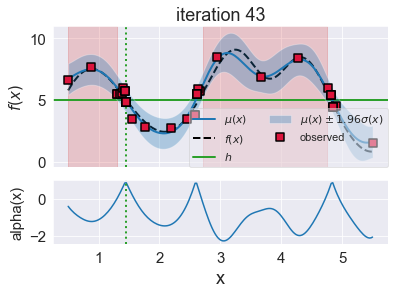

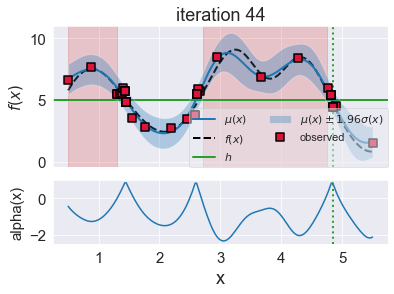

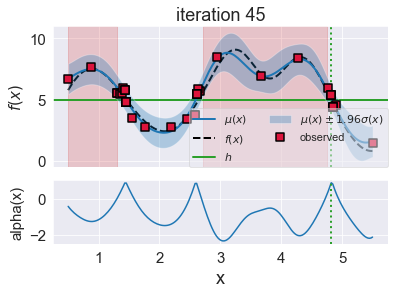

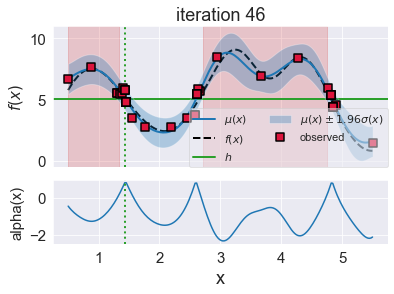

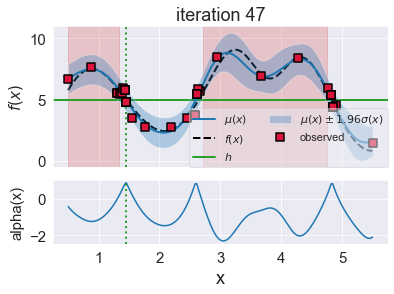

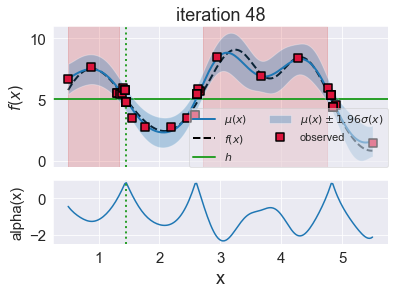

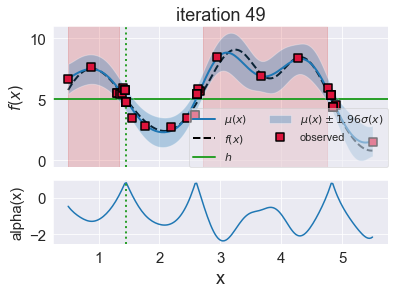

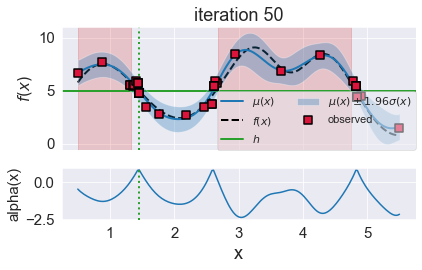

In [21]:
maxitr = 50
pdf = PdfPages("level-set_estimation.pdf")
warnings.simplefilter('ignore', FutureWarning)
for itr in range(maxitr):
    # 尤度関数
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # ガウス過程モデルの定義
    gpr = GPModel(train_X, train_Y, likelihood)
    #print(gpr)

    # 定義したガウス過程の対数周辺尤度
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gpr)  

    # ガウス過程のハイパラ最適化 
        # torchのSGDを使う場合は以下
    all_params = set(gpr.parameters())
    optimizer = torch.optim.Adam(all_params, lr=1e-2) # ガウス過程のハイパラ調整のためのオプティマイザ
    trainer = Trainer(gpr, likelihood, optimizer, mll)
    trainer.update_hyperparameter(2000)

        # BoTorchのfit関数でお手軽最適化する場合は以下
    #fit_gpytorch_model(mll)

    # 未観測の候補点に対する予測
    test_X = torch.from_numpy(np.array(x_current).astype(np.float32)).clone().reshape(len(x_current), 1)
    test_Y = torch.from_numpy(np.array(y_current).astype(np.float32)).clone().reshape(len(y_current))
    gpr.eval()
    likelihood.eval()
    with torch.no_grad():
        predicts = likelihood(gpr(test_X))
        predicts_mean = predicts.mean
        predicts_std = predicts.stddev
    
    post_mean = predicts_mean.detach().numpy().flatten() # 予測平均
    post_std = predicts_std.detach().numpy().flatten() # 予測分散
    post_ci = 1.96 * post_std # 各点の95%信頼区間

    # 候補点の分類
    upper_i = np.where((post_mean - post_ci) > th)
    # print(upper_i)
    upper_range = []
    upper_flag = False
    start = 0
    for xi in np.arange(200):
        if np.any(upper_i == xi):
            if not upper_flag:
                start = xi
                upper_flag = True
        else:
            if upper_flag:
                upper_flag = False
                upper_range.append((start, xi))
            else:
                upper_flag = False
    if upper_flag is True:
        upper_range.append((start, 199))

    # プロット (GPモデル)
    fig = plt.figure()
    gs = plt.GridSpec(3, 1)
    ax = [fig.add_subplot(gs[0:2, 0]), fig.add_subplot(gs[2, 0])]
    ax[0].plot(test_X.flatten(), post_mean, label=r"$\mu(x)$", zorder=2, lw=2)
    ax[0].fill_between(
        test_X.flatten(),
        post_mean - post_ci,
        post_mean + post_ci,
        label=r"$\mu(x) \pm 1.96\sigma(x)$",
        alpha=0.3,
        zorder=2,
    )
    ax[0].plot(
        x.flatten(), f_true.flatten(), c="black", ls="--", label=r"$f(x)$", zorder=1, lw=2
    )
    ax[0].scatter(
        np.array(obs_x),
        np.array(obs_y),
        marker="s",
        s=50,
        color="crimson",
        edgecolor="black",
        lw=1.5,
        zorder=3,
        label="observed",
    )

    ax[0].axhline(th, label=r"$h$", ls="-", c="tab:green", lw=2, zorder=1)

    for r in upper_range:
        ax[0].axvspan(x.flatten()[r[0]], x.flatten()[r[1]], alpha=0.2, color="tab:red")
    
    ax[0].tick_params(labelbottom=False)
    ax[0].set_ylabel(r"$f(x)$")
    ax[0].legend(borderaxespad=0, ncol=2, framealpha=0.5, fontsize=11)
    ax[0].set_title("iteration {}".format(itr + 1))    

   # 獲得関数を最大にする点を選ぶ
    #next_i = np.argmax(post_std) # uncertainty sampling
    ac = straddle(post_mean, post_std, th)
    next_i = np.argmax(ac)

    ax[1].plot(test_X, ac)
    ax[0].axvline(test_X[next_i], ls=":", c="tab:green", lw=2)
    ax[1].axvline(test_X[next_i], ls=":", c="tab:green", lw=2)
    ax[1].set_xlabel("x", fontsize=18)
    ax[1].set_ylabel(r"alpha(x)")

    # データを更新
    obs_x.append(x[next_i])
    obs_y.append(y[next_i])
    #c_best = min(c_best, y[next_i])

    # 既に観測した点は観測しない場合は使用する
    #x_current = np.delete(x_current, next_i)
    #y_current = np.delete(y_current, next_i)
    #f_true_current = np.delete(f_true_current, next_i)

    train_X = torch.from_numpy(np.array(obs_x).astype(np.float32)).clone().reshape(len(obs_x), 1)
    train_Y = torch.from_numpy(np.array(obs_y).astype(np.float32)).clone().reshape(len(obs_y))

fig.tight_layout()
pdf.savefig(fig) 